In [1]:
# list of plots to make
# 1. bar plot of 'table info' without layer specific stuff - just want best performance of each of the different types of models/model names 
# 2. for best model, similar plot but separated by cell type 
# 3. line plot of pretrained models across layers (not separateed by cell type)
# 4. line plot of 3D CNN models across layers 

In [2]:
import os
import numpy as np
from glob import glob
from collections import defaultdict
import argparse
import pickle
import pandas as pd

def parse_filename(filename):
    base = os.path.basename(filename).replace(".npy", "")
    parts = base.split("_")
    if len(parts) < 5:
        raise ValueError(f"Unexpected filename format: {filename}")
    dv = parts[0]
    model = parts[2]
    size = int(parts[3])
    layer = parts[4]
    return dv, model, size, layer

def compute_stats(data):
    mean = np.mean(data)
    stderr = np.std(data, ddof=1) / np.sqrt(len(data))
    return mean, stderr

def get_df(log_dir="../encoding/logs/", dset='dorsal'):
    # Load the dataframe
    with open("../dataset/dorsal_stream_neuron_table.pickle", "rb") as f:
        df = pickle.load(f)
    # Load the dataframe
    with open("../dataset/dorsal_stream_dataset.pickle", "rb") as f:
        dataset = pickle.load(f)    
    
    files = glob(os.path.join(log_dir, "*_test.npy"))
    results = defaultdict(list)  # key: (model_disp, layer_disp) -> list of (size, mean, stderr)

    max_mean = -np.inf
    max_entry = (None, None, None, None)  # (mean, model_disp, layer_disp, size)
        
    for f in files:
        dv, model, size, layer = parse_filename(f)

        if dv == dset and ((model in ['r3d18', 'gabor3d'] and size == 224) or (model in ['dorsalnet', 'resnet18'] and size == 112)):
            data = np.load(f) ** 2 # square corr to average for each neuron to compute r2
            uids = np.arange(len(data))
            new_df = pd.DataFrame({'neuron_uid': uids, f'{model}_{layer}': data})
            df = pd.merge(df, new_df, left_on=['neuron_uid'], right_on=['neuron_uid'])
        elif dv == dset and 'simple3d' in model and 'res' not in model:
            #layer = model[-1]
            data = np.load(f) ** 2 # square corr to average for each neuron to compute r2
            uids = np.arange(len(data))
            new_df = pd.DataFrame({'neuron_uid': uids, f'{model}_{layer}': data})
            df = pd.merge(df, new_df, left_on=['neuron_uid'], right_on=['neuron_uid'])
            
    return df
df = get_df()

In [3]:
model_name_map = {
    'gabor3d': '3D Gabor',
    'r3d18': '3D ResNet - Kinetics',
    'dorsalnet': '3D ResNet - Self Motion',
    'resnet18': '2D ResNet - ImageNet',
    'simple3d1': '3D CNN-1', 
    'simple3d3': '3D CNN-3', 
    'simple3d5': '3D CNN-5',
    'simple3d7': '3D CNN-7',
}

model_training_map = {
    'gabor3d': 'aHand-tuned',
    'r3d18': 'bPretrained',
    'dorsalnet': 'bPretrained',
    'resnet18': 'bPretrained',
    'simple3d1': 'cEnd-to-end', 
    'simple3d3': 'cEnd-to-end', 
    'simple3d5': 'cEnd-to-end',
    'simple3d7': 'cEnd-to-end',
}    

layer_name_map = {
    'gabor3d': {'layer1': 'Simple', 'layer2': 'Complex'},
    'r3d18': {f'layer{i}': f'Layer {i}' for i in range(1, 5)},
    'dorsalnet': {'s1': 'Layer 1', 'res0': 'Layer 2', 'res1': 'Layer 3', 'res2': 'Layer 4'},
    'resnet18': {f'layer{i}': f'Layer {i}' for i in range(1, 5)},
    'simple3d1': {f'none': f'Layer 1'},
    'simple3d3': {f'none': f'Layer 3'},
    'simple3d5': {f'none': f'Layer 5'},
    'simple3d7': {f'none': f'Layer 7'},
}

In [4]:
# for each model & layer compute mean performance 
models = model_name_map.keys()

model_perf = {}

for model in models:
    layer_names = layer_name_map[model].keys()
    model_perf[model] = {}

    for layer in layer_names:
        mean_per = np.nanmean(df[f"{model}_{layer}"])
        sem_per = np.nanstd(df[f"{model}_{layer}"])/np.sqrt(df[f"{model}_{layer}"].shape[0])
        model_perf[model][layer] = {}
        model_perf[model][layer]['mean'] = mean_per
        model_perf[model][layer]['sem'] = sem_per

In [5]:
all_model_names = []
all_perf = []
all_sem = []
all_layer_names = []
all_model_scheme = []

for model in models: 
    for layer in list(layer_name_map[model].keys()):
        opt = model_perf[model][layer]['mean']
        opt_sem = model_perf[model][layer]['sem']
        
        all_perf.append(opt)
        all_sem.append(opt_sem)
        all_model_names.append(model_name_map[model])
        all_layer_names.append(layer_name_map[model][layer])
        all_model_scheme.append(model_training_map[model])
    

{'3D Gabor': <BarContainer object of 1 artists>, '3D ResNet - Kinetics': <BarContainer object of 1 artists>, '3D ResNet - Self Motion': <BarContainer object of 1 artists>, '2D ResNet - ImageNet': <BarContainer object of 1 artists>, '3D CNN': <BarContainer object of 1 artists>}


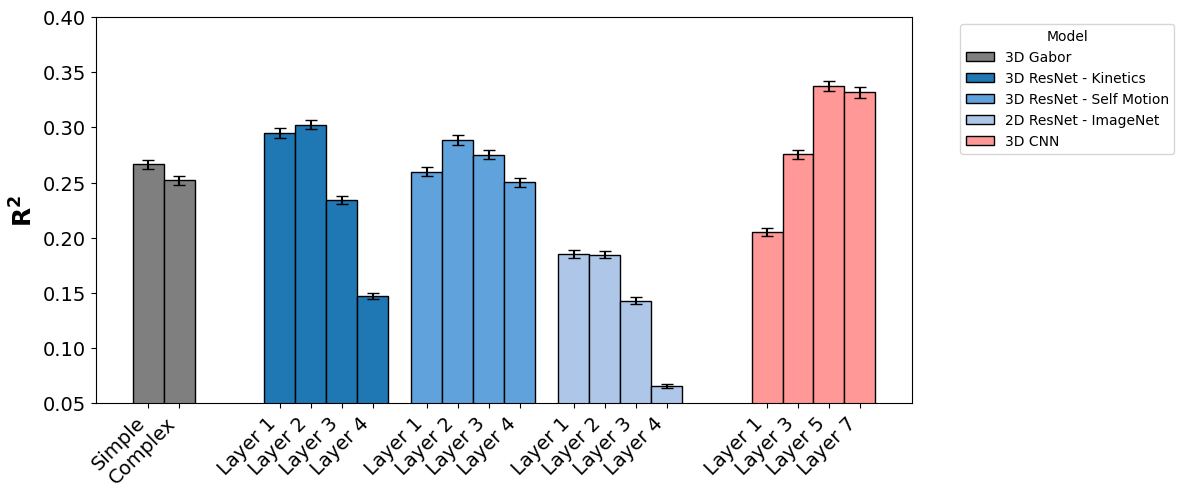

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Normalize model names (group all '3D CNN-*' under '3D CNN')
def normalize_model_name(name):
    return '3D CNN' if '3D CNN' in name else name

norm_model_names = [normalize_model_name(n) for n in all_model_names]

# Create DataFrame
df = pd.DataFrame({
    'Scheme': all_model_scheme,
    'Layer': all_layer_names,
    'Model': norm_model_names,
    'Performance': all_perf,
    'SEM': all_sem
})

# Get plotting order
schemes = df['Scheme'].unique()
models = df['Model'].unique()
colors = plt.cm.Set2.colors

colors = [
    "#7f7f7f",        # gray shades (hand-tuned)
    "#1f77b4", "#5fa2dc", "#aec7e8",  # blue shades (pretrained)
    "#ff9896"
]

color_map = {model: colors[i % len(colors)] for i, model in enumerate(models)}

# Create group structure
grouped_data = []
x_labels = []
bar_positions = []
bar_width = 0.2
spacing = 0.3
x = 0

fig, ax = plt.subplots(figsize=(12, 5))

for scheme in schemes:
    scheme_df = df[df['Scheme'] == scheme]
    scheme_models = scheme_df['Model'].unique()
    for i, model in enumerate(models):
        model_entries = scheme_df[scheme_df['Model'] == model]
        if not model_entries.empty:
            for _, row in model_entries.iterrows():
                ax.bar(x, row['Performance'], yerr=row['SEM'], capsize=4,
                       color=color_map[model], width=bar_width, edgecolor='k', label=model)
                x_labels.append(f"{row['Layer']}") # {scheme[1:]}\n
                bar_positions.append(x)
                x += bar_width
            x += spacing/2
    x += spacing  # extra space between schemes

# Final plot formatting
ax.set_xticks(bar_positions,)
plt.yticks(fontsize=14)

ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)
ax.set_ylabel("$\mathbf{R^2}$", fontsize=18)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
print(unique)
ax.legend(unique.values(), unique.keys(), title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.ylim([0.05, 0.4])
plt.savefig("figures/model_bar_plot.pdf")
plt.show()


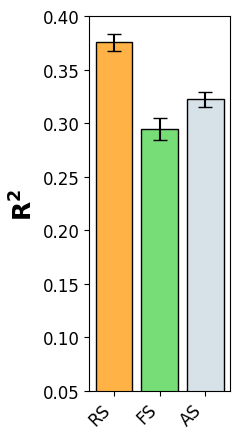

In [7]:
import matplotlib.pyplot as plt

# now for the 3D CNN layer 5 model - plot performance over cell types
# for each model & layer compute mean performance 
models = model_name_map.keys()

ct_perf = {}

model = 'simple3d5'
layer = 'none'
df = get_df()
for ct in ['FS', 'AS', 'RS']: 
    mean_per = np.nanmean(df.loc[df['template_type'] == ct, f"{model}_{layer}"])
    sem_per = np.nanstd(df.loc[df['template_type'] == ct, f"{model}_{layer}"])/np.sqrt(df.loc[df['template_type'] == ct, f"{model}_{layer}"].shape[0])

    ct_perf[ct] = {}
    ct_perf[ct]['mean'] = mean_per
    ct_perf[ct]['sem'] = sem_per

color_map = {
    'FS': '#77DD77',  # green
    'RS': '#FFB347',  # orange
    'AS': '#d6e2e7'   # light gray-blue
}

# Plot data
labels = list(ct_perf.keys())
labels = ['RS', 'FS', 'AS']
means = [ct_perf[ct]['mean'] for ct in labels]
sems = [ct_perf[ct]['sem'] for ct in labels]
colors = [color_map[ct] for ct in labels]

# Plot
fig, ax = plt.subplots(figsize=(2.5, 4.5))
bars = ax.bar(labels, means, yerr=sems, capsize=5, color=colors, edgecolor='black')

ax.set_ylabel("$\mathbf{R^2}$", fontsize=18)
ax.set_ylim(0, max(means) + 0.05)
plt.ylim([0.05, 0.4])
ax.set_xticks([0, 1, 2],)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
# Optional: prettier ticks
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.savefig("figures/model_celltype_perf.pdf")
plt.show()
